In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')

In [3]:
!mkdir images_train
!mkdir images_train/0
!mkdir images_train/1
!mkdir images_train/2
!mkdir images_train/3
!mkdir images_train/4
!mkdir images_train/5
!mkdir images_train/6
!mkdir images_train/7
!mkdir images_train/8
!mkdir images_train/9
!mkdir images_test

In [4]:
import cv2

for idx in range(len(train)) :
    img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
    digit = train.loc[idx, 'digit']
    cv2.imwrite(f'./images_train/{digit}/{train["id"][idx]}.png', img)

In [5]:
import cv2

for idx in range(len(test)) :
    img = test.loc[idx, '0':].values.reshape(28, 28).astype(int)
    cv2.imwrite(f'./images_test/{test["id"][idx]}.png', img)

In [6]:
import tensorflow as tf
DenseNet201_model = tf.keras.applications.DenseNet201(weights=None, include_top=True, input_shape=(224, 224, 1), classes=10)

In [7]:
from tensorflow.keras.optimizers import Adam
DenseNet201_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.002,epsilon=None), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

train_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), color_mode='grayscale', class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), color_mode='grayscale', class_mode='categorical', subset='validation')

Found 1642 images belonging to 10 classes.
Found 406 images belonging to 10 classes.


In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/DACON_CVLC/Checkpoint/CVLC_06_DenseNet201.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [10]:
DenseNet201_model.fit_generator(train_generator, epochs=500, validation_data=val_generator, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
52/52 [==============================] - 61s 433ms/step - loss: 1.9561 - accuracy: 0.3210 - val_loss: 26.5396 - val_accuracy: 0.0985

Epoch 00001: val_accuracy improved from -inf to 0.09852, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/CVLC_06_DenseNet201.h5
Epoch 2/500
52/52 [==============================] - 17s 325ms/step - loss: 1.3088 - accuracy: 0.5700 - val_loss: 27.1447 - val_accuracy: 0.1133

Epoch 00002: val_accuracy improved from 0.09852 to 0.11330, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/CVLC_06_DenseNet201.h5
Epoch 3/500
52/52 [==============================] - 17s 325ms/step - loss: 0.9719 - accuracy: 0.6803 - val_loss: 5.0242 - val_accuracy: 0.0813

Epoch 00003: val_accuracy did not improve from 0.11330
Epoch 4/500
52/52 [==============================] - 17s 322ms/step - loss: 0.7992 - accuracy: 0.7393 - val_loss: 6.8712 - val_accuracy: 0.0985

Epoch 00004: val_accuracy did not improve from 0.11330
Epoch 5/500
52/52 [====

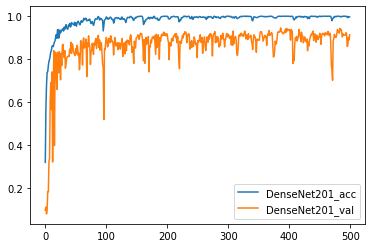

In [11]:
import matplotlib.pyplot as plt

plt.plot(DenseNet201_model.history.history["accuracy"], label='DenseNet201_acc')
plt.plot(DenseNet201_model.history.history["val_accuracy"], label='DenseNet201_val')

plt.legend()
plt.show()

In [12]:
DenseNet201_model = tf.keras.models.load_model('/content/drive/MyDrive/DACON_CVLC/Checkpoint/CVLC_06_DenseNet201.h5', compile=False)

In [ ]:
!mkdir images_test/none
!mv images_test/*.png images_test/none

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory('./images_test', target_size=(224,224), color_mode='grayscale', class_mode='categorical', shuffle=False)

In [15]:
DenseNet201_predict = DenseNet201_model.predict_generator(test_generator).argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/submission.csv')
submission.head()

In [ ]:
import numpy as np
mylist = []

for i in range(len(submission)):
    name =  test_generator.filenames
    id = name[i].split('/')[1].rstrip('.').split('.')[0]
    mylist.append(id)
print(mylist)

In [ ]:
for i in range(len(submission)):
    submission["id"][i] = mylist[i]

In [19]:
submission["DenseNet201_predict"] = DenseNet201_predict
submission.head()

,id,digit,DenseNet201_predict
0,10000,0,4
1,10001,0,4
2,10002,0,6
3,10003,0,9
4,10004,0,5


In [20]:
from collections import Counter

for i in range(len(submission)) :
    predicts = submission.loc[i, ['DenseNet201_predict']]
    submission.at[i, "digit"] = Counter(predicts).most_common(n=1)[0][0]

submission.head()

,id,digit,DenseNet201_predict
0,10000,4,4
1,10001,4,4
2,10002,6,6
3,10003,9,9
4,10004,5,5


In [ ]:
submission = submission[['id', 'digit']]
submission.head()

In [22]:
from google.colab import files

submission.to_csv('/content/drive/MyDrive/DACON_CVLC/Submission/DenseNet201_model.csv', index=False)
files.download('/content/drive/MyDrive/DACON_CVLC/Submission/DenseNet201_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>